# Project: Investigate a Dataset - No-shows appointment

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

The dataset, a record of about 110,00 medical appointments in brazil focuses on whether a patient showed up for a scheduled appointment. The dataset contains 14 variables (columns) which are:

- PatientId - Identification of the patient
- AppointmentID - Identification of the appointment
- Gender - (M)ale or (F)emale
- ScheduledDay - The day the patient set up the appointment
- AppointmentDay - The  day of the appointment
- Age - Age of the patient
- Neighbourhood - The location of the hospital.
- Scholarship - Whether or not the patient was enrolled in the Brazilian welfare program (0 = False, 1 = True)
- Hipertension - Whether or not the patient had Hypertension (0 = False, 1 = True)
- Diabetes - Was the patient diabetic? (0 = False, 1 = True)
- Alcoholism - Was the patient an alcoholic? (0 = False, 1 = True)
- Handcap - Was the patient handicapped? (0 = False, 1 = True)
- SMS_received - One (1) or more messages sent to the patient
- No-show - Did the patient not show up for the appointment? (No = Patient showed up, Yes = Patient did **not**)

More information about the dataset can be found [here](https://www.kaggle.com/datasets/joniarroba/noshowappointments)


### Question(s) for Analysis

What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment? Specifically:

1. Which gender is more likely to miss an appointment?
2. Does the length of days between the schedule date and appointment date affect No-show?
3. Does sending SMS reduce the number of No-shows?
4. Are those in the Brazilian welfare program more likely to keep an appointment?
5. Does the presence of any of the conditions (Hypertension, Diabetes, Alcoholism and Handicap) influence Noshow?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Upgrade pandas to use dataframe.explode() function. 
# !pip install --upgrade pandas==0.25.0

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [3]:
# load the data
df = pd.read_csv('Database_No_show_appointments/noshowappointments-kagglev2-may-2016.csv')

In [4]:
# let's see the first five rows
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [5]:
# How many rows and columns does the data have?
df.shape

(110527, 14)

In [6]:
# inspect data types and look for instances of missing or possibly errant data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


There are no missing data in any of the variables, however the **ScheduledDay** and **AppointmentDay** are not in the right types. Also **Hipertension** variable was wrongly spelt.

In [7]:
# Check the data for duplicates
df.duplicated().sum()

0


### Data Cleaning

 The following will be done to clean up the dataset for the sake of the intended analysis:

- Drop irrelevant variables (PatientId, AppointmentID, Neighbourhood)
- Rename variables for correctness (Hipertension, Handcap) and consistency (SMS_received, No-show)
- Convert ScheduledDay and AppointmentDay to the appropriate type (datetime)
- Keep only rows where the AppointmentDay is greater or same as the ScheduledDay

In [8]:
# Drop irrelevant columns/variables
df_clean = df.copy() # Make a copy of the original dataset for fallback or reference if neccessary

df_clean.drop(['PatientId', 'AppointmentID', 'Neighbourhood'], axis=1, inplace=True)

# view the columns left
df_clean.columns

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Scholarship',
       'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received',
       'No-show'],
      dtype='object')

In [9]:
# Rename variables for correctness and consistency
columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'SMS_received': 'SmsReceived', 'No-show': 'NoShow'}
df_clean.rename(columns=columns, inplace=True)

df_clean.head(2)

,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,NoShow
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,0,1,0,0,0,0,No
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,0,0,0,0,0,0,No


In [10]:
# Convert ScheduledDay and AppointmentDay to the appropriate type (datetime)
df_clean.ScheduledDay = pd.to_datetime(df_clean.ScheduledDay)
df_clean.AppointmentDay = pd.to_datetime(df_clean.AppointmentDay)

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 11 columns):
Gender            110527 non-null object
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handicap          110527 non-null int64
SmsReceived       110527 non-null int64
NoShow            110527 non-null object
dtypes: datetime64[ns](2), int64(7), object(2)
memory usage: 9.3+ MB


In [11]:
# Keep only rows where AppointmentDay >= ScheduledDay
df_clean['ActualDateTimeDifference'] = df_clean.AppointmentDay - df_clean.ScheduledDay

# calculate the length of days (appointment day inclusive) from scheduled date
df_clean['LenDays'] = df_clean['ActualDateTimeDifference'] .dt.days + 1

df_clean[['ScheduledDay', 'AppointmentDay', 'ActualDateTimeDifference',  'LenDays', 'NoShow']].head(10)

,ScheduledDay,AppointmentDay,ActualDateTimeDifference,LenDays,NoShow
0,2016-04-29 18:38:08,2016-04-29,-1 days +05:21:52,0,No
1,2016-04-29 16:08:27,2016-04-29,-1 days +07:51:33,0,No
2,2016-04-29 16:19:04,2016-04-29,-1 days +07:40:56,0,No
3,2016-04-29 17:29:31,2016-04-29,-1 days +06:30:29,0,No
4,2016-04-29 16:07:23,2016-04-29,-1 days +07:52:37,0,No
5,2016-04-27 08:36:51,2016-04-29,1 days 15:23:09,2,No
6,2016-04-27 15:05:12,2016-04-29,1 days 08:54:48,2,Yes
7,2016-04-27 15:39:58,2016-04-29,1 days 08:20:02,2,Yes
8,2016-04-29 08:02:16,2016-04-29,-1 days +15:57:44,0,No
9,2016-04-27 12:48:25,2016-04-29,1 days 11:11:35,2,No


In [12]:
df_clean.LenDays.describe()

count    110527.000000
mean         10.183702
std          15.254996
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: LenDays, dtype: float64

Wait!, we have appointments (e.g. -6 days) before schedule?. The above table shows us that days with values of 0 are actually appointments scheduled for the **same** day. We remove the row(s) with LenDays < 0.

In [13]:
# get the indices of rows we want to drop 
indices = df_clean[df_clean.LenDays < 0].index

# remove the rows
df_clean.drop(indices, inplace=True)

df_clean.LenDays.describe()

count    110522.000000
mean         10.184253
std          15.255115
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: LenDays, dtype: float64

<a id='eda'></a>
## Exploratory Data Analysis


### Which gender is more likely to miss an appointment?

In [14]:
# Determine the proportions of males and females
df_clean.Gender.value_counts(normalize=True)

F    0.649979
M    0.350021
Name: Gender, dtype: float64

65% of the patients were females while the rest 35% were males

In [15]:
def create_grouped_data(key):
    """
    Create a pandas grouped data with the provided key
    Args:
        key (str) - The key provided to the pandas DataFrame groupby method
    Returns:
        A pandas grouped data
    """
    return df_clean.groupby(key).NoShow.value_counts(normalize=True) * 100


gender_noshow = create_grouped_data('Gender')

In [16]:
def create_side_by_side_barchart(grouped_data, keys, labels=None, colors=('b', 'g'), 
                                 title='', ylab='Proportion(%)', xlab='No Show'):
    """
     A helper function that creates a side by side (dodged) bar chart
     Args:
       grouped_data (pandas.core.series.Series) - The data created by pandas DataFrame groupby method
       keys         (iterable) - A list or tuple of category or levels of the variable passed to the groupby method
       labels       (iterable) - labels to use as the plot legend
       ylab         (str) - Y-axis label of the plot
       xlab         (str) - X-axis label of the plot
     Returns:
       None
    """
    
    index = np.arange(grouped_data[keys[0]].count())
    width = 0.35
    
    if labels is None:
        labels = keys

    plt.bar(index, grouped_data[keys[0]], width, color=colors[0], label=labels[0])
    plt.bar(index + width, grouped_data[keys[1]], width, color=colors[1], label=labels[1])

    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.title(title)
    plt.xticks(index + width / 2, ['No', 'Yes'] * 2) # add xtick labels

    # # legend
    plt.legend();

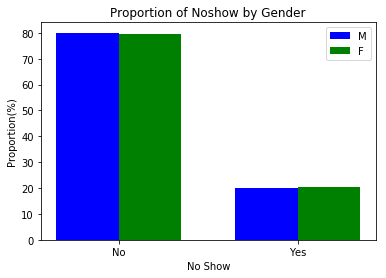

In [17]:
create_side_by_side_barchart(gender_noshow, keys=('M', 'F'), title='Proportion of Noshow by Gender')

The same proportion (approx. 20%) of males and females did not show up for the scheduled appointment. This implied that Noshow is not influenced by gender.

### Does the length of days between the schedule date and appointment date affect No-show?

*It is pertinent to note that taking the days component alone (LenDays) meant a loss of the time component*. My interest here is the days difference so it suffices for this question.

In [18]:
# I intend to use LenDays as a categorical variable since Noshow is a categorical variable
# let's see the 128 unique days
print('The {} unique days are: '.format(df_clean.LenDays.nunique()))
df_clean.LenDays.unique()

The 129 unique days are: 


array([  0,   2,   3,   1,   4,   9,  29,  10,  23,  11,  18,  17,  14,
        28,  24,  21,  15,  16,  22,  43,  30,  31,  42,  32,  56,  45,
        46,  39,  37,  38,  44,  50,  60,  52,  53,  65,  67,  91,  66,
        84,  78,  87, 115, 109,  63,  70,  72,  57,  58,  51,  59,  41,
        49,  73,  64,  20,  33,  34,   6,  35,  36,  12,  13,  40,  47,
         8,   5,   7,  25,  26,  48,  27,  19,  61,  55,  62, 176,  54,
        77,  69,  83,  76,  89,  81, 103,  79,  68,  75,  85, 112,  80,
        86,  98,  94, 142, 155, 162, 169, 104, 133, 125,  96,  88,  90,
       151, 126, 127, 111, 119,  74,  71,  82, 108, 110, 102, 122, 101,
       105,  92,  97,  93, 107,  95, 139, 132, 179, 117, 146, 123])

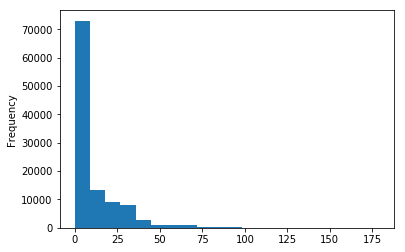

In [19]:
# Let's see the distribution of the length of days
df_clean.LenDays.plot.hist(bins=20);

In [20]:
# A helper function to group the days
# We could further collapse the groups than what was done here
def group_days(days):
    """
      Categorize number of days
      Args:
         days (int) - The days to group
      Returns:
         An integer between 0 and 8 (inclusive)
    """
    if days == 0:
        return 0
    elif days <= 3:
        return 1
    elif days <= 7:
        return 2
    elif days <= 14:
        return 3
    elif days <= 30:
        return 4
    elif days <= 60:
        return 5
    elif days <= 90:
        return 6
    elif days <= 120:
        return 7
    elif days <= 150:
        return 8
    elif days <= 180:
        return 9

df_clean['LenDaysGroup'] = df_clean.LenDays.map(group_days)

df_clean.LenDaysGroup.value_counts()

0    38563
2    17510
4    17371
1    14675
3    12025
5     8283
6     1878
7      132
9       56
8       29
Name: LenDaysGroup, dtype: int64

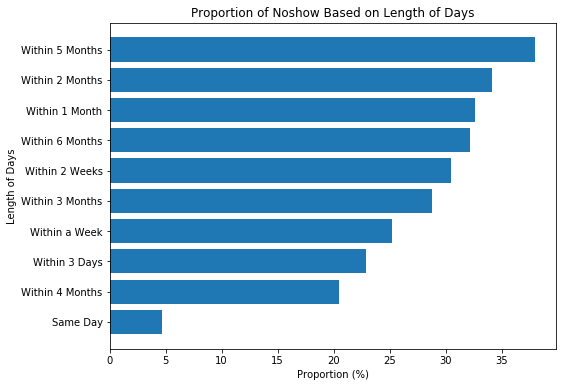

In [21]:
days_group_noshow = create_grouped_data('LenDaysGroup')


noshow_yeses = [val for index, val in enumerate(days_group_noshow) if index % 2 != 0]
labels = ['Same Day', 'Within 3 Days', 'Within a Week', 'Within 2 Weeks', 'Within 1 Month', 'Within 2 Months', 'Within 3 Months', 
                   'Within 4 Months', 'Within 5 Months', 'Within 6 Months']
index = np.arange(len(noshow_yeses))

# combine the index, yeses and labels so that it can be sorted accurately
data = list(zip(noshow_yeses, labels))

# sort the data by the yeses
data.sort(key=lambda x: x[0])

# transpose to the right shape for plotting: data[0] is now the index
data = list(zip(*data))

plt.figure(figsize=(8, 6))
plt.barh(index, data[0])
plt.xlabel('Proportion (%)')
plt.ylabel('Length of Days')
plt.title('Proportion of Noshow Based on Length of Days')
plt.yticks(index, data[1])
plt.show();

We see that less than 5% of same day (zero-day) appointments were not kept. The story is very different when the day of appointment is much later than the scheduled day.

**Note that we could drill further into length of days with respect to gender and presence of disease or type of disease**

### Does sending SMS reduce the number of No-shows?

In [22]:
# Find the proportion of those that were sent sms
df_clean.SmsReceived.value_counts(normalize=True)

0    0.67896
1    0.32104
Name: SmsReceived, dtype: float64

About 32% of the patients were sent 1 or more SMS

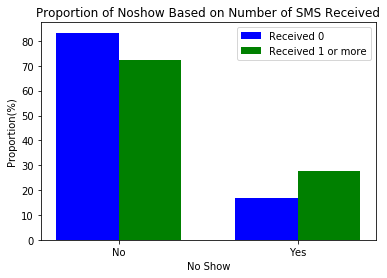

In [23]:
sms_noshow = create_grouped_data('SmsReceived')

labels = ('Received 0', 'Received 1 or more')
title = 'Proportion of Noshow Based on Number of SMS Received'
create_side_by_side_barchart(sms_noshow, keys=(0, 1), title=title, labels=labels)

27.6% of those who received 1 or more SMS did not show up for their appointments while 16.7% of those who did not receive any sms did not show up for their appointments.

### Are those in the Brazilian welfare program more likely to keep an appointment?

In [24]:
# How many people are in the welfare program?

# df_clean.Scholarship.value_counts(normalize=True) * 100
# Same as below

df_clean.Scholarship.mean() * 100 # We can do this because the column contains only 0s and 1s

9.8270027686795398

9.8% of the population were in the Brazilian welfare program

Scholarship  NoShow
0            No        80.196867
             Yes       19.803133
1            No        76.263696
             Yes       23.736304
Name: NoShow, dtype: float64


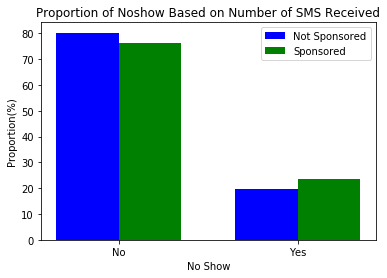

In [25]:
scholarship_noshow = create_grouped_data('Scholarship')
print(scholarship_noshow)
labels = ('Not Sponsored', 'Sponsored')
title = 'Proportion of Noshow Based on Number of SMS Received'

create_side_by_side_barchart(scholarship_noshow, keys=(0, 1), title=title, labels=labels)

About 23.7% of those who were on welfare program missed their appointments while about 20% of those who were not did not keep their appointment.

### Does the Presence of any of the Conditions Influence NoShow?

In [26]:
has_any_condition = (df_clean.Hypertension == 1) | (df_clean.Diabetes == 1) | (df_clean.Alcoholism == 1)  | (df_clean.Handicap == 1)

df_condition = df_clean[has_any_condition]
df_no_condition = df_clean[has_any_condition == False]

print('{:.2f}% of the population had at least 1 of the listed conditions'.format(len(df_condition) / len(df_clean) * 100))
print('{:.2f}% of the population had none of the listed conditions'.format(len(df_no_condition) / len(df_clean) * 100))

23.80% of the population had at least 1 of the listed conditions
76.20% of the population had none of the listed conditions


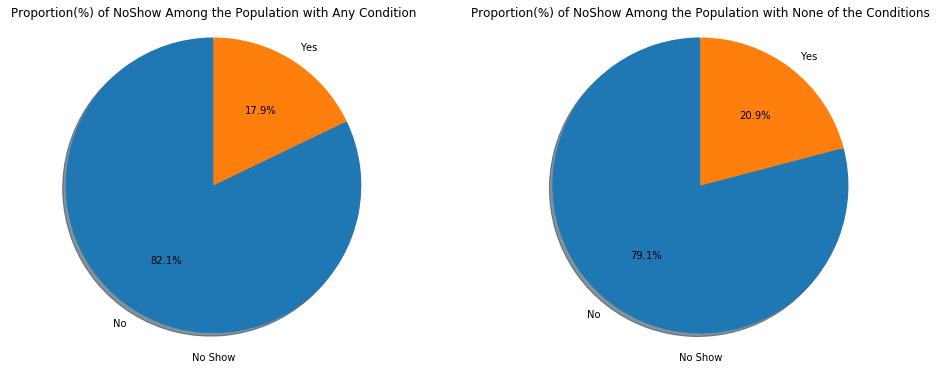

In [27]:
condition_noshow = df_condition.NoShow.value_counts(normalize=True) * 100
no_condition_noshow = df_no_condition.NoShow.value_counts(normalize=True) * 100

fig = plt.figure(figsize=(16, 6))
ax1, ax2 = fig.subplots(1, 2)

ax1.pie(condition_noshow, labels=condition_noshow.index, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Proportion(%) of NoShow Among the Population with Any Condition')
ax1.set_xlabel("No Show")

ax2.pie(no_condition_noshow, labels=no_condition_noshow.index, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.axis('equal')
ax2.set_title('Proportion(%) of NoShow Among the Population with None of the Conditions')
ax2.set_xlabel("No Show")

plt.show()

A larger proportion (20.9%) of those without any condition did not keep their appointments.

<a id='conclusions'></a>
## Conclusions

**Firstly, it is pertinent to note that this analysis is tentative**.
Gender did not seem to influence the missing of hospital appointments (NoShow) among the population. Also, the length of days between scheduled date and appointment day seems to play a row on NoShow as 0 days (same-day) appointments were less missed.
The reception of SMS seemed to influence NoShow. However, more insight could be gained if presence of disease or the length of days were considered along with receiving SMS. More proportion of those sponsored also missed their appointment relative to those who were not sponsored. Finally, more people without any condition (3% more than those with any condition) missed their appointment. Here also, we could probe further by checking which of the conditions (Hypertension or Diabetes or Alcoholism or Handicap) had more of NoShow.


### Limitations

The current analysis does not perform any hypothesis test which is necessary to provide concrete answers to the research questions.
Secondly, statistically modelling (logistic regression) was not performed. This would give insights on the combination of factors that would predict NoShow.

In [28]:
# Create Html File Needed For Project Submission
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0